# Fathom Technical Assessment
*GG, 1 August 2022*

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
class scraper:
    
    def ParFetch_url(self):
        fetched = requests.get('https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(17)30819-X/fulltext')
        ftext = fetched.text
        bsc = bs(ftext, 'lxml')
        tbl = bsc.find('table')
        data_r = tbl.findAll('tr')
        return data_r
    
    def BuilData(self, data):
        row = []
        for d in data:
            row.append([r.text for r in d])
        return np.array(row)
    
    def fixData(self, arr):
        data_dict = {arr[0][i]:arr[1:].T[i] for i in [2,3,4,5]}
        data_dict['Country'] = arr[1:].T[0]
        data_DF = pd.DataFrame(data_dict)
        data_DF.replace({'·':'.', '−':'-'}, inplace = True, regex = True) 
        for i in range(4):
            data_DF[data_DF.columns[i]] = data_DF[data_DF.columns[i]].apply(lambda x: float(x.partition(" (")[0]))
        return data_DF
    
    def PPCH(self, df):
        le_DF = pd.DataFrame()
        fq = df[df.columns[2]].apply(lambda x: math.pow(1+(x/100), 25))
        mq = df[df.columns[3]].apply(lambda x: math.pow(1+(x/100), 25))
        Fperc95 = df[df.columns[0]]/fq
        Mperc95 = df[df.columns[1]]/mq
        le_DF['Change in female rate'] = df[df.columns[0]]-Fperc95
        le_DF['Change in male rate'] = df[df.columns[1]]-Mperc95
        le_DF['SgnF'] = le_DF['Change in female rate'].apply(lambda x: 1 if x>0 else 0)
        le_DF['SgnM'] = le_DF['Change in male rate'].apply(lambda x: 1 if x>0 else 0)
        le_DF['Code'] = [f'{i}{j}' for i,j in zip(list(le_DF.SgnF), list(le_DF.SgnM))]
        le_DF['Color'] = le_DF['Code'].map({'00': 'lightskyblue', '10': 'steelblue', 
                                               '01':'salmon', '11':'firebrick'})
        le_DF['Country'] = df.Country
        le_DF.replace({'UK':'Britain'}, inplace = True, regex = True)
        
        return le_DF[le_DF.columns[[6,0,1,4,5]]]
    
    def run(self):
        dta = self.ParFetch_url()
        lss = self.BuilData(dta)
        lss_DF = self.fixData(lss)
        les_DF = self.PPCH(lss_DF)
        return les_DF

In [3]:
scr = scraper()

In [4]:
DF = scr.run()

In [5]:
countries = ['South Korea', 'Japan', 'Turkey', 'Denmark', 'Brazil', 'Norway', 'Iceland', 'Nepal', 'India', 'Canada', 'Sweden', 'Britain', 'France', 'China', 'Belarus', 'USA', 'Portugal', 'Greece', 'Bulgaria', 'Russia', 'Kuwait', 'Timor-Leste', 'Tonga', 'Chile', 'Indonesia', 'Cyprus', 'Macedonia', 'Montenegro', 'Azerbaijan', 'Saudi Arabia']
coords = [[-27,6.9], [-27,6.0], [-27,-14.7], [-27,-15.6], [3,6.9], [3,6.0], [3,-14.7], [3,-15.6]]
mapd = {6.9: 'Female increase', 3: 'male increase', -14.7: 'Female decrease', -27: 'male decrease'}
sgn = {-1.0:['steelblue', '',  'salmon'], 1.0:['deepskyblue', '',  'firebrick']}
mapp = lambda x: 1 if x%2 == 0 else 0

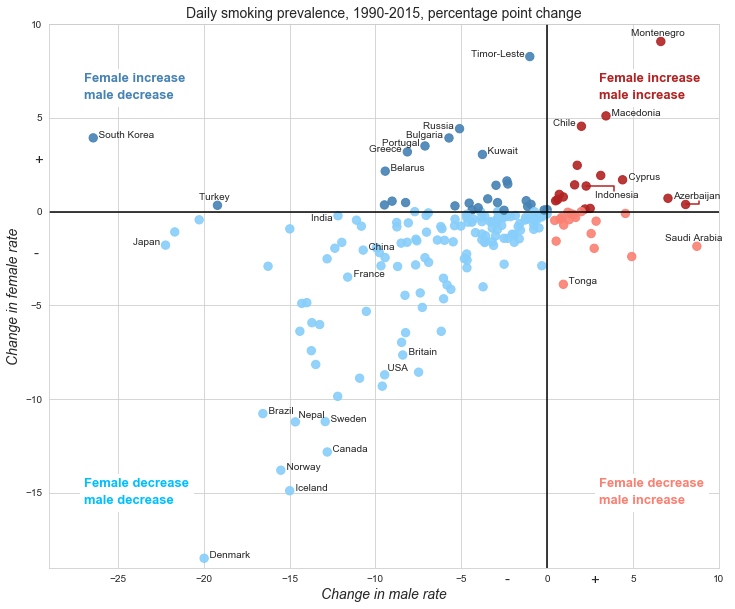

In [6]:
figure(figsize=(12, 10))
sns.set_style("whitegrid")

plt.scatter(x = 'Change in male rate', y = 'Change in female rate', color = DF.Color, alpha = 0.9, s = 70, data = DF)
plt.axvline(0, color='black')
plt.axhline(0, color='black')


for c in countries:
    if c in ['Russia', 'Chile', 'Bulgaria', 'Portugal', 'Greece', 'Japan', 'Timor-Leste']:
        plt.text(DF[DF.Country == c]['Change in male rate'].values[0], DF[DF.Country == c]['Change in female rate'].values[0], f"{c}  ", in_layout = True, rasterized = True,horizontalalignment = 'right', verticalalignment = 'baseline', wrap = False)
    elif c in ['Montenegro', 'Turkey', 'Saudi Arabia']:
        plt.text(DF[DF.Country == c]['Change in male rate'].values[0], DF[DF.Country == c]['Change in female rate'].values[0]+0.2, f"{c}  ", in_layout = True, rasterized = True,horizontalalignment = 'center', verticalalignment = 'bottom', wrap = False)
    elif c == 'Indonesia':
        plt.text(DF[DF.Country == c]['Change in male rate'].values[0]+.5, DF[DF.Country == c]['Change in female rate'].values[0]-.5, f"{c}  ", in_layout = True, rasterized = True,horizontalalignment = 'left', verticalalignment = 'center', wrap = False)
        plt.plot([DF[DF.Country == c]['Change in male rate'].values[0]+1.6,DF[DF.Country == c]['Change in male rate'].values[0]+1.6,DF[DF.Country == c]['Change in male rate'].values[0]], [DF[DF.Country == c]['Change in female rate'].values[0]-.25, DF[DF.Country == c]['Change in female rate'].values[0], DF[DF.Country == c]['Change in female rate'].values[0]], color = 'firebrick')
    elif c == 'Azerbaijan':
        plt.text(DF[DF.Country == c]['Change in male rate'].values[0]+.8, DF[DF.Country == c]['Change in female rate'].values[0]+.2, f"{c}  ", in_layout = True, rasterized = True,horizontalalignment = 'center', verticalalignment = 'bottom', wrap = False)
        plt.plot([DF[DF.Country == c]['Change in male rate'].values[0],DF[DF.Country == c]['Change in male rate'].values[0]+.8, DF[DF.Country == c]['Change in male rate'].values[0]+.8], [DF[DF.Country == c]['Change in female rate'].values[0],DF[DF.Country == c]['Change in female rate'].values[0], DF[DF.Country == c]['Change in female rate'].values[0]+0.2], color = 'firebrick')
    elif c == 'India':
        plt.text(DF[DF.Country == c]['Change in male rate'].values[0], DF[DF.Country == c]['Change in female rate'].values[0]+.1, f"{c}  ", in_layout = True, rasterized = True,horizontalalignment = 'right', verticalalignment = 'top', wrap = False)
    elif c in ['Nepal', 'USA']:
        plt.text(DF[DF.Country == c]['Change in male rate'].values[0]-.14, DF[DF.Country == c]['Change in female rate'].values[0]+.21, f"  {c}", in_layout = True, rasterized = True, wrap = False)
    else:
        plt.text(DF[DF.Country == c]['Change in male rate'].values[0], DF[DF.Country == c]['Change in female rate'].values[0], f"  {c}", in_layout = True, rasterized = True, wrap = False)

j = 2
for i in range(len(coords)):
    plt.text(coords[i][0], coords[i][1], mapd[coords[i][mapp(j)]], color = sgn[np.sign(coords[i][0]*coords[i][1])][1+np.sign(coords[i][0])], size = 13, fontweight = 'bold', bbox=dict(facecolor='white', alpha=1))                                                                            
    j+=1

plt.xlabel(DF.columns[2], fontsize = 14, style = 'italic')
plt.ylabel(DF.columns[1], fontsize = 14, style = 'italic')
plt.title('Daily smoking prevalence, 1990-2015, percentage point change', fontsize = 14, fontweight = 'medium')

plt.text(-2.5, -19.898, '-', fontsize = 15)
plt.text(2.5, -19.898, '+', fontsize = 15)
plt.text(-29.898,-2.5, '-', fontsize = 15)
plt.text(-29.898,2.5, '+', fontsize = 15)
plt.xlim(-29, 10)
plt.ylim(-19, 10)

plt.show()
    